In [ ]:
!rm -r sample_data

### Setting up venv

In [ ]:
!pip install virtualenv

     |████████████████████████████████| 5.6 MB 15.2 MB/s 
     |████████████████████████████████| 496 kB 60.7 MB/s 


In [ ]:
!virtualenv env

created virtual environment CPython3.7.12.final.0-64 in 783ms
  creator CPython3Posix(dest=/content/env, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==21.3.1, setuptools==58.3.0, wheel==0.37.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [ ]:
!source env/bin/activate

### Requirements

In [ ]:
!pip install numpy

In [ ]:
!pip install pandas

In [ ]:
!pip install matplotlib

In [ ]:
!pip install librosa

In [ ]:
!pip install pytube

     |████████████████████████████████| 56 kB 3.7 MB/s 


In [ ]:
!pip3 install torch==1.10.0+cpu torchvision==0.11.1+cpu torchaudio==0.10.0+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cpu/torch_stable.html
     |████████████████████████████████| 199.3 MB 63 kB/s 
     |████████████████████████████████| 16.2 MB 57 kB/s 
     |████████████████████████████████| 2.7 MB 385 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111


### Fetching Data

In [ ]:
!mkdir data

In [ ]:
# Downloading audio

from pytube import YouTube
import librosa

def fetch_audio(url, save_path):
    yt = YouTube(url)
    print(f'Downloading {yt.title}')
    audio = yt.streams.get_by_itag(251)
    audio.download(save_path)


video_url = 'https://youtu.be/HtSuA80QTyo'
save_location = '/content/data/'
fetch_audio(video_url, save_location)

In [ ]:
## Convert to wav

from scipy.io import wavfile

def convert_to_wav(input_path, output_path):
    aud = librosa.load(input_path)
    wavfile.write(output_path, aud[1], aud[0])

convert_to_wav('/content/data/1 Algorithmic Thinking Peak Finding.webm', '/content/data/WavAudio.wav')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
!wget 'https://raw.githubusercontent.com/visheshks04/speech-recognition/master/data/captions_data.json'

--2021-11-15 02:17:39--  https://raw.githubusercontent.com/visheshks04/speech-recognition/master/data/captions_data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132177 (129K) [text/plain]
Saving to: ‘captions_data.json’

captions_data.json  100%[===================>] 129.08K  --.-KB/s    in 0.008s  

2021-11-15 02:17:40 (15.2 MB/s) - ‘captions_data.json’ saved [132177/132177]



In [ ]:
!mv captions_data.json data/captions_data.json

In [ ]:
# Making key value pairs json

import json

data = []

with open('data/captions_data.json', 'r') as f:
    captions_data = json.load(f)

for event in captions_data['events']:
    sample = dict()
    sample["key"] = 'data/clips/' + str(event['tStartMs']) + '.wav'
    sample["text"] = event['segs'][0]['utf8']
    data.append(sample)


with open('data/dataset.json', 'w') as f:
    json.dump(data, f, indent=4)

In [ ]:
## Cleaning dataset.json

def clean_data(dataset_path):

    with open(dataset_path, 'r') as f:
        data = json.load(f)

    for event in data:
        sentence = event['text']
        sentence = sentence.replace('\n', ' ')
        sentence = remove_caps(sentence)
        sentence = remove_special_chars(sentence)
        sentence = sentence.lower()
        event['text'] = sentence

    with open(dataset_path, 'w') as f:
        json.dump(data, f, indent=4)


def remove_caps(string):
    string = string.split()
    for word in string:
        if(word.isupper()):
            string.remove(word)
    string = " ".join(string)
    return string

def remove_special_chars(string):

    removables = ['.', ',', ';', '"', '\'', ':', '<', '>', '?', '/', '\\', '[', ']', '{', '}', '-', '_', '+', '=', '(', ')', '!', '@', '#', '$', '%', '^', '&', '*', '~', '`']

    string = list(string)

    for ch in string:
        if ch in removables:
            string.remove(ch)

    string = "".join(string)
    return string

clean_data('data/dataset.json')

In [ ]:
## Chopping clips
!mkdir data/clips/

In [ ]:
with open('data/captions_data.json', 'r') as f:
    data = json.load(f)

aud = librosa.load('data/WavAudio.wav')

for event in data['events']:
    start_index = event['tStartMs'] * 1e-3 * aud[1]
    end_index = (event['tStartMs'] + event['dDurationMs']) * 1e-3 * aud[1]

    start_index, end_index = int(start_index), int(end_index)

    chopped_sample = aud[0][start_index:end_index]
    wavfile.write('data/clips/{}.wav'.format(event['tStartMs']), aud[1], chopped_sample)

### Train dev test split

In [ ]:
def train_dev_test(file_path, train_size = 0.8, dev_size = 0.1):
  with open(file_path, 'r') as f:
    ds = json.load(f)

  n = len(ds)

  train_ind = int(n*train_size)
  dev_ind = int(train_ind + n*dev_size)

  train_set = ds[:train_ind]
  dev_set = ds[train_ind:dev_ind]
  test_set = ds[dev_ind:]

  with open('train.json', 'w') as f:
    json.dump(train_set, f, indent = 4)

  with open('dev.json', 'w') as f:
    json.dump(dev_set, f, indent = 4)

  with open('test.json', 'w') as f:
    json.dump(test_set, f, indent = 4)


train_dev_test('data/dataset.json')

In [ ]:
## Mel Spectrogram transform

import torchaudio
import torch.nn as nn

class LogMelSpec(nn.Module):

    def __init__(self, sample_rate=8000, n_mels=128, win_length=160, hop_length=80):
        super(LogMelSpec, self).__init__()
        self.transform = torchaudio.transforms.MelSpectrogram(
                            sample_rate=sample_rate, n_mels=n_mels,
                            win_length=win_length, hop_length=hop_length)

    def forward(self, x):
        x = self.transform(x)  # mel spectrogram
        x = np.log(x + 1e-14)  # logrithmic, add small value to avoid inf
        return x

In [ ]:
import torch

## Encode/Decode label sequences

class TextProcess:
	def __init__(self):
		char_map_str = """
		' 0
		<SPACE> 1
		a 2
		b 3
		c 4
		d 5
		e 6
		f 7
		g 8
		h 9
		i 10
		j 11
		k 12
		l 13
		m 14
		n 15
		o 16
		p 17
		q 18
		r 19
		s 20
		t 21
		u 22
		v 23
		w 24
		x 25
		y 26
		z 27
		"""
		self.char_map = {}
		self.index_map = {}
		for line in char_map_str.strip().split('\n'):
			ch, index = line.split()
			self.char_map[ch] = int(index)
			self.index_map[int(index)] = ch
		self.index_map[1] = ' '

	def text_to_int_sequence(self, text):
		""" Use a character map and convert text to an integer sequence """
		int_sequence = []
		for c in text:
			if c == ' ':
				ch = self.char_map['<SPACE>']
			else:
				ch = self.char_map[c]
			int_sequence.append(ch)
		return int_sequence

	def int_to_text_sequence(self, labels):
		""" Use a character map and convert integer labels to an text sequence """
		string = []
		for i in labels:
			string.append(self.index_map[i])
		return ''.join(string).replace('<SPACE>', ' ')


textprocess = TextProcess()

def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
	arg_maxes = torch.argmax(output, dim=2)
	decodes = []
	targets = []
	for i, args in enumerate(arg_maxes):
		decode = []
		targets.append(textprocess.int_to_text_sequence(
				labels[i][:label_lengths[i]].tolist()))
		for j, index in enumerate(args):
			if index != blank_label:
				if collapse_repeated and j != 0 and index == args[j -1]:
					continue
				decode.append(index.item())
		decodes.append(textprocess.int_to_text_sequence(decode))
	return decodes, targets

In [ ]:
from torch.nn import functional as F

class ActDropNormCNN1D(nn.Module):
    def __init__(self, n_feats, dropout, keep_shape=False):
        super(ActDropNormCNN1D, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(n_feats)
        self.keep_shape = keep_shape
    
    def forward(self, x):
        x = x.transpose(1, 2)
        # x = self.norm(self.dropout(F.gelu(x)))
        x = self.dropout(F.gelu(self.norm(x)))
        if self.keep_shape:
            return x.transpose(1, 2)
        else:
            return x

class SpeechRecognition(nn.Module):
    hyper_parameters = {
        "num_classes": 29,
        "n_feats": 81,
        "dropout": 0.1,
        "hidden_size": 1024,
        "num_layers": 1
    }

    def __init__(self, hidden_size, num_classes, n_feats, num_layers, dropout):
        super(SpeechRecognition, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.cnn = nn.Sequential(
            nn.Conv1d(n_feats, n_feats, 10, 2, padding=10//2),
            ActDropNormCNN1D(n_feats, dropout),
        )
        self.dense = nn.Sequential(
            nn.Linear(n_feats, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(dropout),
        )
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size,
                            num_layers=num_layers, dropout=0.0,
                            bidirectional=False)
        self.layer_norm2 = nn.LayerNorm(hidden_size)
        self.dropout2 = nn.Dropout(dropout)
        self.final_fc = nn.Linear(hidden_size, num_classes)

    def _init_hidden(self, batch_size):
        n, hs = self.num_layers, self.hidden_size
        return (torch.zeros(n*1, batch_size, hs),
                torch.zeros(n*1, batch_size, hs))

    def forward(self, x, hidden):
        x = x.squeeze(1)  # batch, feature, time
        x = self.cnn(x) # batch, time, feature
        x = self.dense(x) # batch, time, feature
        x = x.transpose(0, 1) # time, batch, feature
        out, (hn, cn) = self.lstm(x, hidden)
        x = self.dropout2(F.gelu(self.layer_norm2(out)))  # (time, batch, n_class)
        return self.final_fc(x), (hn, cn)

In [ ]:
h_params = SpeechRecognition.hyper_parameters
model = SpeechRecognition(**h_params)
model.state_dict()

OrderedDict([('cnn.0.weight',
              tensor([[[-0.0027,  0.0264,  0.0169,  ..., -0.0072, -0.0241, -0.0061],
                       [-0.0235, -0.0347,  0.0058,  ..., -0.0096,  0.0243, -0.0251],
                       [-0.0181,  0.0128,  0.0021,  ...,  0.0078, -0.0116, -0.0240],
                       ...,
                       [ 0.0089,  0.0193, -0.0231,  ..., -0.0106,  0.0332, -0.0311],
                       [ 0.0182, -0.0017,  0.0210,  ..., -0.0154,  0.0217, -0.0246],
                       [ 0.0280, -0.0140, -0.0104,  ...,  0.0106,  0.0010, -0.0315]],
              
                      [[-0.0149, -0.0284, -0.0035,  ..., -0.0059,  0.0307,  0.0103],
                       [ 0.0312,  0.0178,  0.0047,  ..., -0.0100,  0.0169, -0.0018],
                       [ 0.0264, -0.0162, -0.0214,  ..., -0.0228, -0.0075, -0.0224],
                       ...,
                       [ 0.0115, -0.0227, -0.0112,  ..., -0.0058,  0.0012, -0.0111],
                       [ 0.0130, -0.0229,  0.027

In [ ]:
import pandas as pd
import numpy as np

class Data(torch.utils.data.Dataset):

    # this makes it easier to be ovveride in argparse
    parameters = {
        "sample_rate": 8000, "n_feats": 81,
        "specaug_rate": 0.5, "specaug_policy": 3,
        "time_mask": 70, "freq_mask": 15 
    }

    def __init__(self, json_path, sample_rate, n_feats, specaug_rate, specaug_policy,
                time_mask, freq_mask, shuffle=True, text_to_int=True, log_ex=True):
        self.log_ex = log_ex
        self.text_process = TextProcess()

        print("Loading data json file from", json_path)
        self.data = pd.read_json(json_path)

        self.audio_transforms = torch.nn.Sequential(
            LogMelSpec(sample_rate=sample_rate, n_mels=n_feats,  win_length=160, hop_length=80)
        )
        # else:
        #     self.audio_transforms = torch.nn.Sequential(
        #         LogMelSpec(sample_rate=sample_rate, n_mels=n_feats,  win_length=160, hop_length=80),
        #         SpecAugment(specaug_rate, specaug_policy, freq_mask, time_mask)
        #     )


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()

        try:
            file_path = self.data.key.iloc[idx]
            waveform, _ = torchaudio.load(file_path)
            label = self.text_process.text_to_int_sequence(self.data['text'].iloc[idx])
            spectrogram = self.audio_transforms(waveform) # (channel, feature, time)
            spec_len = spectrogram.shape[-1] // 2
            label_len = len(label)
            if spec_len < label_len:
                raise Exception('spectrogram len is bigger then label len')
            if spectrogram.shape[0] > 1:
                raise Exception('dual channel, skipping audio file %s'%file_path)
            if spectrogram.shape[2] > 1650:
                raise Exception('spectrogram to big. size %s'%spectrogram.shape[2])
            if label_len == 0:
                raise Exception('label len is zero... skipping %s'%file_path)
        except Exception as e:
            if self.log_ex:
                print(str(e), file_path)
            return self.__getitem__(idx - 1 if idx != 0 else idx + 1)  
        return spectrogram, label, spec_len, label_len

def collate_fn_padd(data):
    '''
    Padds batch of variable length
    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitrary tensors.
    '''
    # print(data)
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (spectrogram, label, input_length, label_length) in data:
        if spectrogram is None:
            continue
       # print(spectrogram.shape)
        spectrograms.append(spectrogram.squeeze(0).transpose(0, 1))
        labels.append(torch.Tensor(label))
        input_lengths.append(input_length)
        label_lengths.append(label_length)

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)
    input_lengths = input_lengths
    # print(spectrograms.shape)
    label_lengths = label_lengths
    # ## compute mask
    # mask = (batch != 0).cuda(gpu)
    # return batch, lengths, mask
    return spectrograms, labels, input_lengths, label_lengths

In [ ]:
learning_rate = 1e-3
epochs = 8
batch_size = 128

optimizer = torch.optim.Adam(model.parameters(), learning_rate)
criterion = nn.CTCLoss(blank=28, zero_infinity=True)

train_data = Data(json_path='train.json', **Data.parameters)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, collate_fn=collate_fn_padd, shuffle=True)

final_losses = []
avg_losses = []

for epoch in range(epochs):

    batch_idx = 0

    batch_losses = []

    for spectrograms, labels, input_lengths, label_lengths in train_loader:
        bs = spectrograms.shape[0]
        hidden = model._init_hidden(bs)
        hn, c0 = hidden[0], hidden[1]
        output, _ = model(spectrograms, (hn, c0))
        output = F.log_softmax(output, dim=2)
        labels = torch.tensor(labels)
        loss = criterion(output, labels, input_lengths, label_lengths)

        batch_losses.append(loss)
        final_losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'EPOCH #{epoch+1}; BATCH IDX {batch_idx+1}; LOSS: {loss}')

        batch_idx += 1

    avg = sum(batch_losses)/len(batch_losses)
    print(f'\n\nAVERAGE LOSS FOR EPOCH {epoch+1}: LOSS: {avg}')
    avg_losses.append(avg)
    

Loading data json file from train.json
'-' data/clips/2410529.wav
'-' data/clips/2406890.wav
'-' data/clips/2158500.wav
'-' data/clips/2156750.wav
'2' data/clips/1716680.wav
'-' data/clips/1713420.wav
'-' data/clips/1691010.wav
'-' data/clips/1233230.wav
'-' data/clips/2388630.wav
'-' data/clips/2383270.wav
'-' data/clips/2378920.wav
'5' data/clips/203170.wav
'2' data/clips/2083660.wav
'-' data/clips/1560777.wav
'2' data/clips/1770010.wav
'-' data/clips/1764570.wav
'-' data/clips/2014530.wav
'1' data/clips/2011310.wav
label len is zero... skipping data/clips/1219610.wav data/clips/1219610.wav
'-' data/clips/1627750.wav
'1' data/clips/2327810.wav
'-' data/clips/982770.wav
'-' data/clips/978240.wav
'6' data/clips/412080.wav
label len is zero... skipping data/clips/1195210.wav data/clips/1195210.wav
'-' data/clips/301640.wav
label len is zero... skipping data/clips/1993630.wav data/clips/1993630.wav
'-' data/clips/1959680.wav
spectrogram to big. size 2112 data/clips/1129680.wav
label len 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


EPOCH #1; BATCH IDX 1; LOSS: 32.27993392944336
'6' data/clips/400880.wav
'-' data/clips/773240.wav
spectrogram to big. size 3242 data/clips/2210490.wav
spectrogram to big. size 2467 data/clips/2201540.wav
'-' data/clips/2300850.wav
'-' data/clips/1511200.wav
'6' data/clips/40210.wav
'2' data/clips/1147930.wav
'1' data/clips/1145360.wav
'-' data/clips/309600.wav
'1' data/clips/257750.wav
'-' data/clips/275320.wav
'-' data/clips/1564790.wav
'-' data/clips/1562860.wav
'-' data/clips/1560777.wav
'-' data/clips/1406340.wav
'-' data/clips/1398340.wav
'-' data/clips/1608580.wav
'-' data/clips/517350.wav
'-' data/clips/508580.wav
spectrogram to big. size 2660 data/clips/2363750.wav
label len is zero... skipping data/clips/2117820.wav data/clips/2117820.wav
'1' data/clips/2114160.wav
'1' data/clips/2106170.wav
'-' data/clips/2101860.wav
'-' data/clips/2097440.wav
'1' data/clips/1737680.wav
'-' data/clips/1730950.wav
'2' data/clips/1716680.wav
'-' data/clips/1713420.wav
',' data/clips/1539219.wa

In [ ]:
torch.save(model, 'SpeechModel.pt')
torch.save(model.state_dict(), 'SpeechModelStateDict.pt')

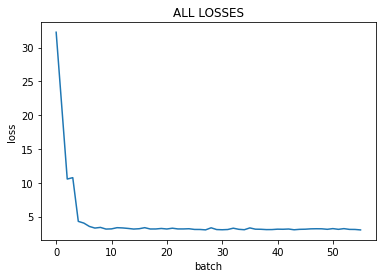

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(final_losses)), final_losses)
plt.xlabel('batch')
plt.ylabel('loss')
plt.title('ALL LOSSES')
plt.savefig('AllLosses.png')

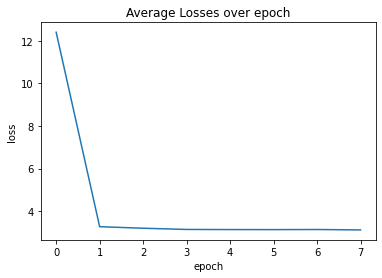

In [ ]:
plt.plot(range(len(avg_losses)), avg_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Average Losses over epoch')
plt.savefig('AverageLosses.png')